In [1]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

In [2]:
class rellis_dataset(Dataset):
    """
    Using 6 classes
    """
    def __init__(self, data_root_dir, txt_file, transform=None, target_transform=None):
        """
        data_root_dit: root directory of the dataset, e.g. './data/rellis'
        txt_file: path to the train.txt listing image files
        
        """
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.target_transform = target_transform
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_root_dir, 'image', self.image_paths[index] + '.jpg')
        ann_path = os.path.join(self.data_root_dir, 'annotation', self.image_paths[index] + '_group6.png')
        image = Image.open(img_path).convert('RGB')
        annotation = Image.open(ann_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        annotation = (annotation*256).long() # turn the label to the interger
        return image, annotation

In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
]) 
dataset = rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/test.txt', transform=transform, target_transform=target_transform)


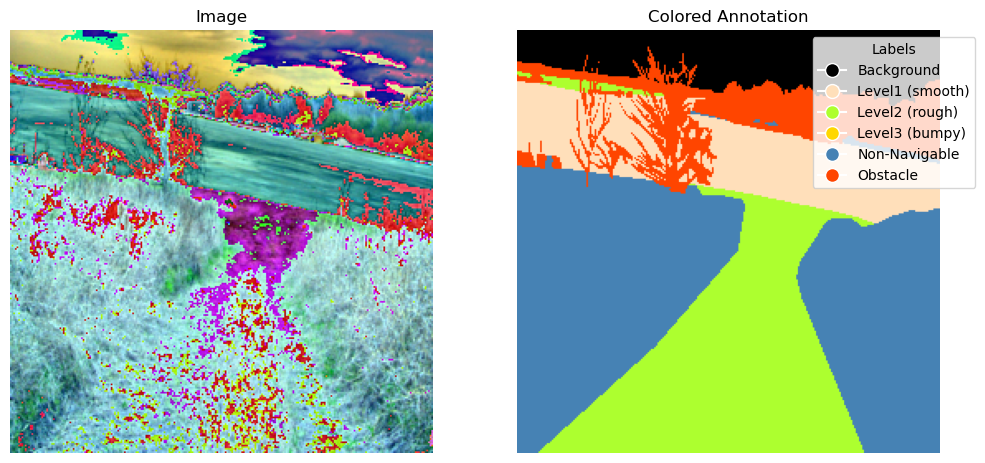

In [4]:
label_colors = {
    0: [0, 0, 0],         # Background: black
    1: [255, 223, 186],   # Level1 (smooth) - Navigable: light peach
    2: [173, 255, 47],    # Level2 (rough) - Navigable: light green
    3: [255, 215, 0],     # Level3 (bumpy) - Navigable: gold
    4: [70, 130, 180],     # Non-Navigable (forbidden): steel blue
    5: [255, 69, 0],      # Obstacle: crimson
}
label_names = {
    0: "Background",
    1: "Level1 (smooth)",
    2: "Level2 (rough)",
    3: "Level3 (bumpy)",
    4: "Non-Navigable",
    5: "Obstacle",
}
def decode_segmap(annotation):
    annotation_np = annotation.squeeze(0).numpy() 
    color_annotation = np.zeros((annotation_np.shape[0], annotation_np.shape[1], 3), dtype=np.uint8)

    for label, color in label_colors.items():
        color_annotation[annotation_np == label] = color

    return color_annotation


image, annotation = dataset[101]
color_annotation = decode_segmap(annotation)


# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ToPILImage()(image))
ax[0].set_title('Image')
ax[0].axis('off')
# Display the annotation with colors
ax[1].imshow(color_annotation)
ax[1].set_title('Colored Annotation')
ax[1].axis('off')

handles = []
for label, color in label_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label_names[label],
                                markerfacecolor=np.array(color) / 255, markersize=10))

ax[1].legend(handles=handles, title="Labels", loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.show()

In [5]:
# from collections import Counter
# import tqdm
# class_counts = Counter()


# dataloader = DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=4)


# for _, annotation in (dataloader):
#     # Flatten the annotation to count each class
#     flattened = annotation.view(-1).numpy()
#     class_counts.update(Counter(flattened))
# print(class_counts)
# # Convert the Counter to a numpy array with counts for classes 0-5
# total_pixels = sum(class_counts.values())
# class_weights = {cls: total_pixels / (len(class_counts) * count) for cls, count in class_counts.items()}

In [6]:
import cv2
import numpy as np
import torch

def generate_boundary_mask(target):
    """
    Generates a binary boundary mask from the segmentation target.

    Args:
        target (torch.Tensor): A tensor of shape (B, H, W) containing class labels.

    Returns:
        torch.Tensor: A binary mask of shape (B, H, W) with boundaries marked as 1.
    """
    # Move target tensor to CPU and convert to numpy
    target_np = target.cpu().numpy().astype(np.uint8)
    
    # Initialize an empty list to store boundary masks
    boundary_masks = []
    
    for i in range(target_np.shape[0]):  # Iterate over each image in the batch
        # Apply Sobel filter to find edges
        sobel_x = cv2.Sobel(target_np[i], cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter in X direction
        sobel_y = cv2.Sobel(target_np[i], cv2.CV_64F, 0, 1, ksize=3)  # Sobel filter in Y direction
        
        # Compute the gradient magnitude
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        
        # Normalize the gradient magnitude to [0, 1]
        gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())
        
        # Threshold to create a binary mask
        _, boundary_mask = cv2.threshold(gradient_magnitude, 0.1, 1, cv2.THRESH_BINARY)  # Adjust threshold as needed

        # Append to the list of boundary masks
        boundary_masks.append(boundary_mask)

    # Convert the list back to a tensor
    # boundary_masks_tensor = torch.tensor(boundary_masks, dtype=torch.float32).to(target.device)
# Convert the list of numpy.ndarrays to a single numpy.ndarray
    boundary_masks_array = np.array(boundary_masks)  # Convert to a single numpy array

    # Then create the tensor from the single numpy array
    boundary_masks_tensor = torch.tensor(boundary_masks_array, dtype=torch.float32).to(target.device)

    return boundary_masks_tensor


In [7]:
b_m = generate_boundary_mask(annotation)


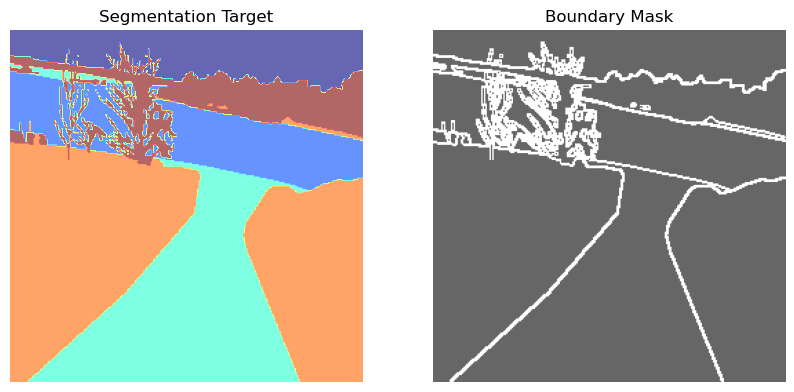

In [8]:
import matplotlib.pyplot as plt

def visualize_boundary(target, boundary_mask, index=0):
    """
    Visualizes the original segmentation target and the generated boundary mask.

    Args:
        target (torch.Tensor): A tensor of shape (B, H, W) containing class labels.
        boundary_mask (torch.Tensor): A tensor of shape (B, H, W) containing binary boundary masks.
        index (int): Index of the image in the batch to visualize.
    """
    # Move tensors to CPU and convert to numpy for visualization
    target_np = target[index].cpu().numpy()
    boundary_mask_np = boundary_mask[index].cpu().numpy()

    # Create a figure with subplots
    plt.figure(figsize=(10, 5))

    # Original Segmentation Map
    plt.subplot(1, 2, 1)
    plt.imshow(target_np, cmap='jet', alpha=0.6)  # Using a colormap for visualization
    plt.title("Segmentation Target")
    plt.axis('off')

    # Boundary Mask
    plt.subplot(1, 2, 2)
    plt.imshow(boundary_mask_np, cmap='gray', alpha=0.6)  # Binary mask in gray scale
    plt.title("Boundary Mask")
    plt.axis('off')

    # Show the plots
    plt.show()

# Example usage
# Assuming `target` is your segmentation tensor and `boundary_mask` is generated
visualize_boundary(annotation, b_m, index=0)


In [9]:
torch.count_nonzero(b_m)

tensor(6551)

In [10]:
b_m.shape

torch.Size([1, 256, 256])